In [1]:
#we are going to import the geracao dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing
import os

In [2]:
dataset = pd.read_csv('data.csv')
#del dataset["Unnamed: 0"]
#print(dataset.head)

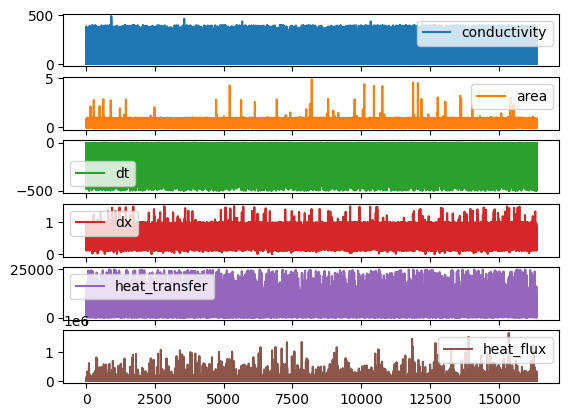

In [3]:
#we are going to plot every single data in the dataset to see how it looks like
dataset.plot(subplots=True)
plt.show()
#saving the plot as a image

In [4]:
#our y or target will be the heat_flx
target = dataset["heat_flux"]
#our x or features will be the rest of the dataset
dados = dataset[["conductivity","area","dt","dx","heat_transfer"]]

In [5]:
print(dados)

       conductivity      area          dt        dx  heat_transfer
0        183.968903  0.161903 -326.138411  0.627135   15489.625053
1         32.438759  0.803663  -20.177422  0.199604    2635.323179
2        357.394961  0.407904   -4.109836  0.350706    1708.391018
3          3.055040  0.888425 -477.651449  0.782922    1655.884077
4         38.856522  0.483578  -45.262789  0.311660    2728.922847
...             ...       ...         ...       ...            ...
16378     78.017424  0.820444  -11.809360  0.328442    2301.487185
16379    286.128497  0.373036  -18.175280  0.785523    2469.643298
16380      3.279339  0.360507 -237.902619  0.279157    1007.515513
16381     47.778890  0.589539  -47.257081  0.457998    2906.377780
16382    165.027654  0.002083 -331.866365  0.744299     153.251054

[16383 rows x 5 columns]


In [6]:
print(target)

0        95672.172898
1         3279.138012
2         4188.218959
3         1863.842705
4         5643.186629
             ...     
16378     2805.172043
16379     6620.384522
16380     2794.716709
16381     4929.916805
16382    73582.196799
Name: heat_flux, Length: 16383, dtype: float64


In [7]:
target = np.array(target)
dados = np.array(dados)

In [8]:
print(dados)

[[ 1.83968903e+02  1.61903138e-01 -3.26138411e+02  6.27134555e-01
   1.54896251e+04]
 [ 3.24387594e+01  8.03663392e-01 -2.01774223e+01  1.99604452e-01
   2.63532318e+03]
 [ 3.57394961e+02  4.07903941e-01 -4.10983628e+00  3.50706300e-01
   1.70839102e+03]
 ...
 [ 3.27933946e+00  3.60507206e-01 -2.37902619e+02  2.79156539e-01
   1.00751551e+03]
 [ 4.77788898e+01  5.89538910e-01 -4.72570814e+01  4.57997766e-01
   2.90637778e+03]
 [ 1.65027654e+02  2.08271920e-03 -3.31866365e+02  7.44298622e-01
   1.53251054e+02]]


In [9]:
#printing the first 10 values of the target
print(target[:10])

[ 95672.17289829   3279.13801231   4188.2189586    1863.84270512
   5643.18662885  69642.16450208   4524.16991494   3257.24835764
    651.9197751  130696.68251693]


In [10]:
#scaling both the target and the features, keep in mind that we can reverse the scaling later
scaler = StandardScaler()
dados = scaler.fit_transform(dados)
target = scaler.fit_transform(target.reshape(-1,1))

In [11]:
X_train_full, x_test, y_train_full, y_test = train_test_split(dados, target, test_size=0.25, random_state=42)


In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

In [13]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3,activation="tanh", input_shape=[5]):
    model = keras.models.Sequential()
    options = {"input_shape": input_shape}
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation=activation, **options))
        options = {}
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [14]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

C:\Users\Saint\AppData\Local\Temp\ipykernel_10776\1709004121.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)


In [15]:
param_distribs = {
    "n_hidden": [0, 1, 2, 3,4,5,6,7,8,9,10],
    "n_neurons": np.arange(5, 256),
    "learning_rate": reciprocal(3e-5, 3e-3),
    "activation": ["tanh"],
}

In [16]:
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=5,n_jobs=1,cv=3)
rnd_search_cv.fit(X_train, y_train, epochs=80,
                    validation_data=(X_valid, y_valid),
                    callbacks=[keras.callbacks.EarlyStopping(patience=5,monitor="val_loss")],verbose=2)

Epoch 1/80


C:\Users\Saint\AppData\Roaming\Python\Python310\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


192/192 - 4s - loss: 0.7271 - val_loss: 0.5604 - 4s/epoch - 19ms/step
Epoch 2/80
192/192 - 1s - loss: 0.6223 - val_loss: 0.5407 - 1s/epoch - 7ms/step
Epoch 3/80
192/192 - 1s - loss: 0.6058 - val_loss: 0.5325 - 1s/epoch - 7ms/step
Epoch 4/80
192/192 - 1s - loss: 0.5980 - val_loss: 0.5286 - 1s/epoch - 7ms/step
Epoch 5/80
192/192 - 1s - loss: 0.5907 - val_loss: 0.5246 - 1s/epoch - 7ms/step
Epoch 6/80
192/192 - 1s - loss: 0.5848 - val_loss: 0.5182 - 1s/epoch - 7ms/step
Epoch 7/80
192/192 - 1s - loss: 0.5785 - val_loss: 0.5116 - 1s/epoch - 7ms/step
Epoch 8/80
192/192 - 2s - loss: 0.5740 - val_loss: 0.5078 - 2s/epoch - 8ms/step
Epoch 9/80
192/192 - 1s - loss: 0.5690 - val_loss: 0.5041 - 1s/epoch - 7ms/step
Epoch 10/80
192/192 - 1s - loss: 0.5637 - val_loss: 0.5018 - 1s/epoch - 7ms/step
Epoch 11/80
192/192 - 1s - loss: 0.5593 - val_loss: 0.4948 - 1s/epoch - 7ms/step
Epoch 12/80
192/192 - 1s - loss: 0.5543 - val_loss: 0.4927 - 1s/epoch - 7ms/step
Epoch 13/80
192/192 - 1s - loss: 0.5493 - val_l

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x00000254F9BEFA30>,
                   n_iter=5, n_jobs=1,
                   param_distributions={'activation': ['tanh'],
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000254F9C56B90>,
                                        'n_hidden': [0, 1, 2, 3, 4, 5, 6, 7, 8,
                                                     9, 10],
                                        'n_neurons': array([  5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16...
       161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
       174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186,
       187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199,
       200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212,
       213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225,
       226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238,
       239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251,
       252, 253, 254, 255])})

In [17]:
model = rnd_search_cv.best_estimator_.model

In [18]:
hist = model.history.history

In [19]:
rnd_search_cv.best_params_

{'activation': 'tanh',
 'learning_rate': 0.0017531550990418875,
 'n_hidden': 6,
 'n_neurons': 119}

In [20]:
rnd_search_cv.best_score_

-0.015069110629459223

In [21]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_90 (Dense)            (None, 119)               714       
                                                                 
 dense_91 (Dense)            (None, 119)               14280     
                                                                 
 dense_92 (Dense)            (None, 119)               14280     
                                                                 
 dense_93 (Dense)            (None, 119)               14280     
                                                                 
 dense_94 (Dense)            (None, 119)               14280     
                                                                 
 dense_95 (Dense)            (None, 119)               14280     
                                                                 
 dense_96 (Dense)            (None, 1)               

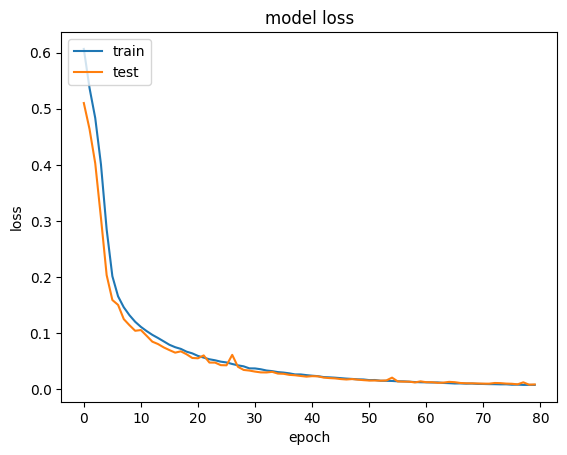

In [22]:
#ploting the loss and the validation loss
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()


In [23]:
#average of the loss and the val loss
#weighted average
loss = hist["loss"]
val_loss = hist["val_loss"]
average_loss = np.average(loss)
average_val_loss = np.average(val_loss)
print("average loss: ", average_loss)
print("average val loss: ", average_val_loss)


average loss:  0.06603080385830254
average val loss:  0.05785928611876443


In [24]:
mse_test = model.evaluate(x_test, y_test)

128/128 [==============================] - 0s 3ms/step - loss: 0.0132


In [25]:
#ploting the predictions and the actual values
y_pred = model.predict(x_test)
y_pred = y_pred.flatten()
#ploting the predictions and the actual values

128/128 [==============================] - 0s 2ms/step


In [26]:
#ploting the predictions and the actual values
print(y_test[0:10])

[[ 0.01480283]
 [-0.3716791 ]
 [-0.12941581]
 [ 2.08933724]
 [-0.19555976]
 [ 0.63373987]
 [-0.40944765]
 [ 1.15183575]
 [ 1.28503316]
 [-0.4059938 ]]


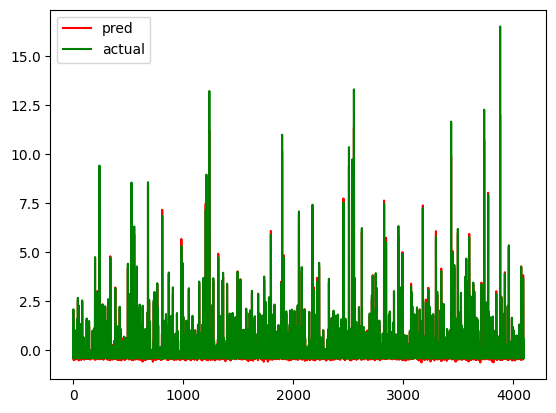

In [27]:
#we have to convert the y_test back to its original shape
#we are going to inverse the scaling of the y_pred, since we scaled it before
#inverse scaling both the y_pred and the y_test
#y_pred = scaler.inverse_transform(y_pred.reshape(-1,1))
#y_test = scaler.inverse_transform(y_test.reshape(-1,1))

plt.plot(y_pred, color="red", label="pred")
plt.plot(y_test, color="green", label="actual")
plt.legend(loc="upper left")
plt.show()

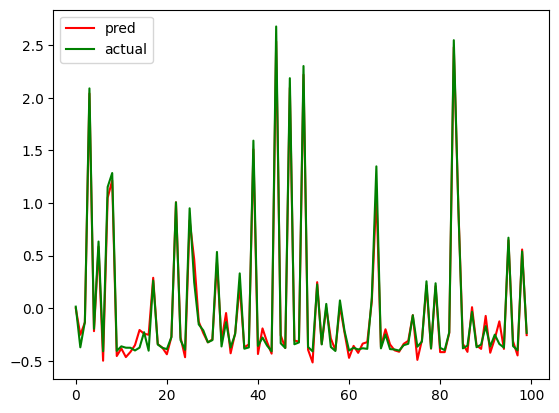

In [28]:
#plotting just the first 100 predictions and values
plt.plot(y_pred[:100], color="red", label="pred")
plt.plot(y_test[:100], color="green", label="actual")
plt.legend(loc="upper left")
plt.show()


In [29]:
#measuring the total error, the mean absolute error and the mean squared error
total_error = 0
total_pred = 0
total_test = 0
for i in range(len(y_pred)):
    total_pred = total_pred + y_pred[i]
    total_test = total_test + y_test[i]

total_error = (total_pred - total_test)/total_test # prediction - actual / actual
print("total error: ", total_error*100, "%")


total error:  [-161.68958536] %


In [30]:
#predicting the first 10 values
for i in range(10):
    print("pred: ", y_pred[i], "actual: ", y_test[i])


pred:  -0.0009966753 actual:  [0.01480283]
pred:  -0.2526025 actual:  [-0.3716791]
pred:  -0.13625969 actual:  [-0.12941581]
pred:  2.0407188 actual:  [2.08933724]
pred:  -0.21830994 actual:  [-0.19555976]
pred:  0.58384854 actual:  [0.63373987]
pred:  -0.49908113 actual:  [-0.40944765]
pred:  1.0492387 actual:  [1.15183575]
pred:  1.2146626 actual:  [1.28503316]
pred:  -0.4546644 actual:  [-0.4059938]


In [31]:
dataset_test = pd.read_csv('teste.csv')


In [32]:
dataset_test.head()

,conductivity,area,dt,dx,heat_transfer,heat_flux
0,25.217044,0.328481,-310.081239,0.913010,2813.226419,8564.343634
1,267.282656,0.053601,-119.694012,0.819830,2091.666009,39022.863767
2,281.979100,0.134270,-342.664598,0.522104,24849.033280,185067.227754
3,87.242757,0.621385,-14.829481,0.283638,2834.343159,4561.330279
4,28.266007,0.444184,-3.029642,0.209479,181.583713,408.803306


In [35]:
#importing the dataset test.csv
dataset_test = pd.read_csv('teste.csv')
#setting up the target and the data
target = dataset_test["heat_flux"]
dados = dataset_test[['conductivity','area','dt','dx','heat_transfer']]
#scaling the data
scaler = StandardScaler()
dados = scaler.fit_transform(dados)
target = target.values.reshape(-1,1)
target = scaler.fit_transform(target)


In [36]:
new_mse_test = model.evaluate(dados, target)

248/248 [==============================] - 1s 5ms/step - loss: 0.0888


In [37]:
#getting the path of every single file that eds with .h5 in the folder
path = os.getcwd()
files = os.listdir(path)
files = [f for f in files if f.endswith(".h5")]

#a partir da linha de cima, teremos uma lista com todos os modelos já salvos na psta

In [38]:
print(files)

[]


In [39]:
#com a linha abaixo iremos obter duas listas, cada uma delas contendo as evaluations de cada modelo previamente salvo,
#para que podemos plotar o gráfico de loss e val_loss geral mais tarde.
mse_list_test = []
mse_list_new_test = []
for i in files:
    model = keras.models.load_model(i)
    mse_new = model.evaluate(dados, target)
    mse_list_new_test.append(mse_new)
    mse_old = model.evaluate(x_test, y_test)
    mse_list_test.append(mse_old)

In [40]:
#average of the evaluations of older models on the test set
average_mse_test = np.average(mse_list_test)
#average o the new evaluations on the test set
average_mse_new_test = np.average(mse_list_new_test)

C:\Users\Saint\AppData\Roaming\Python\Python310\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\Saint\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [41]:
print("average mse test: ", average_mse_test)
print("average mse new test: ", average_mse_new_test)
print("mse test: ", mse_test)
print("mse new test: ", new_mse_test)

average mse test:  nan
average mse new test:  nan
mse test:  0.013157878071069717
mse new test:  0.08880293369293213


In [45]:
#before saving the model, we are going to verify if its evaluation on the test and in the new dataset are smaller
#than the average of the evaluations of the older models

if ((new_mse_test < average_mse_new_test and mse_test < average_mse_test) or (new_mse_test < average_mse_new_test and mse_test > average_mse_test) ):
    #creating a name of the model, based on the date and the amount of hidden layers and neurons
    #name = "model_" + str(datetime.datetime.now()) + "_" + str(rnd_search_cv.best_params_["n_hidden"]) + "_" + str(rnd_search_cv.best_params_["n_neurons"]) + ".h5"
    #name is going to be tha name of the model, which consists in the amount of hidden layers and neurons
    name = "model_" + str(rnd_search_cv.best_params_["n_hidden"]) + "_" + str(rnd_search_cv.best_params_["n_neurons"]) + ".h5"
    model.save(name)
    print("model saved")

In [47]:
#showing the first 10 predctions and the real values
y_pred = model.predict(dados)
y_pred = y_pred.flatten()

for i in range(10):
    print("pred: ", y_pred[i], "actual: ", target[i])

248/248 [==============================] - 1s 3ms/step
pred:  -0.40144068 actual:  [-0.47492909]
pred:  -0.111607 actual:  [-0.16720745]
pred:  1.3782945 actual:  [1.30827498]
pred:  -0.43499523 actual:  [-0.51537143]
pred:  -0.66317374 actual:  [-0.5573243]
pred:  -0.4157365 actual:  [-0.53187086]
pred:  -0.50745416 actual:  [-0.55387574]
pred:  -0.42238775 actual:  [-0.39540789]
pred:  -0.51503396 actual:  [-0.55219203]
pred:  1.1894433 actual:  [1.32442082]


AttributeError: 'numpy.ndarray' object has no attribute 'values'

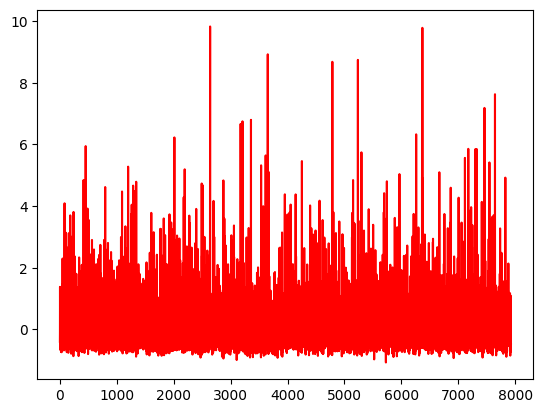

In [48]:
#Plotting the predictions and the real values
plt.plot(y_pred, color="red", label="pred")
plt.plot(target, color="green", label="actual")
plt.legend(loc="upper left")
plt.show()

In [ ]:
#getting all the files that end with .h5
path = os.getcwd()
files = os.listdir(path)
files = [f for f in files if f.endswith(".h5")]


In [ ]:
print(files)

In [ ]:
def arrays_evas(mse_list_test,mse_list_new_test,files):
    for i in files:
        #Printing the filename
        print(i)
        model = keras.models.load_model(i)
        print(model.summary())
        mse_new = model.evaluate(dados, target)
        mse_list_new_test.append(mse_new)
        mse_old = model.evaluate(x_test, y_test)
        mse_list_test.append(mse_old)

In [ ]:
mse_list_new_test = []
mse_list_test = []
arrays_evas(mse_list_test,mse_list_new_test,files)

In [ ]:
print(mse_list_test)

In [ ]:
#ploting the graph of the evaluations of the older models on the test set